In [12]:
import sys
sys.path.append(r'C:\Users\cfg001\Desktop\WTC11')
from ioMicroBogdanVerified import *
from ioMicroPostFits import *

#\\192.168.0.79\Public\Adam\E200_WTC11_WTday3__8_31_2023\AnalysisDeconvolve_CG\combinatorial

In [5]:
#Y:\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG
analysis_folder = r'W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CGBogdanV'
cp=chromatin_postfits(save_folder=analysis_folder,
                      tag='*--H*_B*--col*__Xhfits.npz',exclude_tag = None,tag_save='',remap=True,nHs=23)

[165 142  19 ...  14 111  55]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166]
{0: array(['W:\\Adam\\E217_WTC11_day14_Rad21_CHATDNA\\AnalysisDeconvolve_CGBogdanV\\Conv_zscan__000--H14_B40_41_42--col1__Xhfits.npz',
       'W:\\Adam\\E217_WTC11_day14_Rad21_CHATDNA\\AnalysisDeconvolve_CGBogdanV\\Conv_zscan__000--H18_B52_53_54--col0__Xhfits.npz',
       'W:\\Adam\\E217_WT

In [6]:
#Y:\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG\sequential_segmentation
segmentation_folder = r'W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\segmentationDAPI'
def get_R(fl,letTag='B'): 
        try:
            icol = get_icol(fl)
            return np.array(get_Htag(fl).replace(letTag,'').split('_')[1:],dtype=int)[icol]
        except:
            return -1
def reorder_on_R(fls):
    return np.array(fls)[np.argsort([get_R(fl) for fl in fls])]

def load_segmentation(dec,folder =  segmentation_folder):
    dec.fl_dapi = glob.glob(folder+os.sep+dec.fov+'*'+dec.set_+'*.npz')[0]
    dic = np.load(dec.fl_dapi)
    im_segm = dic['segm']
    dec.shape = dic['shape']
    dec.im_segm_=im_segm
    dec.segm_tag = os.path.basename(dec.fl_dapi).split('--')[1]
def main_func(ifov,redo_fov=False,redo_drift=False,nbest=80,nexpand=5):
    
    
    cp.ifov = ifov
    ### map the files  ##################################
    cp.set_ = ''
    fls = cp.dic_fls[cp.ifov]
    fls = reorder_on_R(fls)
    cp.fov = get_fullfov(fls[0])
    save_fld_cell = cp.save_folder+os.sep+'best_per_cellCFGP2'
    if not os.path.exists(save_fld_cell): os.makedirs(save_fld_cell)
    save_fld_cell_ = save_fld_cell#+'V2'
    if not os.path.exists(save_fld_cell_): os.makedirs(save_fld_cell_)
    cp.save_fl = save_fld_cell_+os.sep+cp.fov+'--'+cp.set_+'__XHfs_finedrft.npz'
    
    if not os.path.exists(cp.save_fl) or redo_fov:
        print("Computing/Loading drift...")
        ### Compute the drift for all hybes #########################
        to_dapi_dic = {fitfl:fit_fl_TO_dapiFeat_fl(fitfl) for fitfl in fls}
        dapi_fls = np.unique(list(to_dapi_dic.values()))
        dapi_fls = list(dapi_fls)

        ########## Add dapi drift features for the segmentation file
        fov__ = cp.fov.replace('.zarr','')
        #Conv_zscan__000--H1_R1_R2_R3--CYTO_segm
        extra_fl = os.path.dirname(segmentation_folder)+os.sep+fov__+'--H1_B1_2_3--dapiFeatures.npz'
        dapi_fls+=[extra_fl]
        
        drift_fl  = save_fld_cell+os.sep+'driftNew_'+cp.fov+'--'+cp.set_+'.pkl'
        if not os.path.exists(drift_fl) or redo_drift:
            fl_ref = dapi_fls[len(dapi_fls)//2]

            dic_drift = {}
            for fl in tqdm(dapi_fls):
                dic_drift[fl] = get_best_translation_pointsV2(fl,fl_ref,resc=5)
                #print(fl,dic_drift[fl])

            pickle.dump([list(dic_drift.values()),list(dic_drift.keys()),cp.fov,fl_ref],open(drift_fl,'wb'))
        else:
            drifts,fls_,fov_,fl_ref = np.load(drift_fl,allow_pickle=True)
            dic_drift = dict(zip(fls_,drifts))
        print("Maximum drift:",np.max([np.abs(dic_drift[key][0]) for key in dic_drift],axis=0))
    
        ### load all the fitted data ##################################
        XH = None
        print("Load the fitted data and apply drift correction to dots...")
        for fl in tqdm(fls):
            #Xhs,dic_drift = pickle.load(open(fl,'rb'))
            Xh = np.load(fl,allow_pickle=True)['Xh']
            if len(Xh.shape)>0:
                Xh = Xh[Xh[:,-2]>0.25] ### filter by correlation with PSF
                drift = dic_drift[to_dapi_dic[fl]][0]
                Xh[:,:3] = Xh[:,:3]+drift ################what sign - this is a plus on Kiwi
                iR = get_R(fl)-1
                icol = get_icol(fl)
                Xh_ = np.concatenate([Xh,np.array([[icol,iR]]*len(Xh))],axis=-1)
                if XH is None:
                    XH = Xh_
                else:
                    XH = np.concatenate([XH,Xh_],axis=0)
        if False:
            ### Visualize to see if the drift correction failed
            resc = [1,1,1]
            XH_ = XH.copy()
            iHs = (XH_[:,-1]).astype(int)
            XH_kp = XH_[iHs==0]
            h = XH_kp[:,-3]
            size = np.clip(h/15000,0,1)*0.2
            x,y = (XH_kp[:,1:3]*resc[1:3]).T
            plt.scatter(x,y,s=size/50,c='r')
            XH_kp = XH_[iHs==80]
            h = XH_kp[:,-3]
            size = np.clip(h/15000,0,1)*0.2
            x,y = (XH_kp[:,1:3]*resc[1:3]).T
            plt.scatter(x,y,s=size/50,c='g')
        print("Loading segmentation...")
        load_segmentation(cp)
        cp.im_segm_ = expand_segmentation(cp.im_segm_, nexpand=nexpand)
        ### Compute drift between the segmentation file and the reference drift file
        print("Compute drift correction segmentation file...")
        tzxy_seg = np.round([dic_drift[key][0] for key in dic_drift if cp.segm_tag in key]).astype(int)
        #tzxy_seg
        
        ### Augment the fitting data with cell id
        resc = cp.im_segm_.shape/cp.shape
        XH_ = XH.copy()
        XH_[:,:3] = XH_[:,:3]-tzxy_seg ### bring fits to cell segmentation space - modified to -
        XC = (XH_[:,:3]*resc).astype(int) #rescale to segmentation size
        keep = np.all(XC>=0,axis=-1)&np.all(XC<cp.im_segm_.shape,axis=-1)
        icells = np.zeros(len(XC))
        icells[keep]=cp.im_segm_[tuple(XC[keep].T)]
        XH_f = np.concatenate([XH_,icells[:,np.newaxis]],axis=-1)
        cp.XH_f=XH_f
        
        ### Keep best fits per cell and exclude background
        print("Keeping best points per cell:"+str(nbest))
        XH_fs = keep_best_per_cell_fast(XH_f,nbest=nbest)
        cp.XH_fs=XH_fs
        np.savez(cp.save_fl,XH_fs=XH_fs)
        print("Saved the augmented fits to file:",cp.save_fl)

In [6]:
### Test for one FOV (i.e. FOV5)

In [7]:
main_func(5)

In [34]:
###load data
XH_f = np.load(cp.save_fl)['XH_fs']
XHB = keep_best_per_cell_fast(XH_f,1)

AttributeError: 'chromatin_postfits' object has no attribute 'save_fl'

In [9]:
import napari
X = XHB[:,:3]
H = XHB[:,-4]
vmax = np.median(H)#,95)
size = np.clip(H/vmax,0,1)*1
V = napari.view_points(X,size=size,blending='Additive',edge_width=0)

### Run EM and check distance matrix

100%|███████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 717.96it/s]


Detected number of chromosomes:158
Number of cells with 1 chromosomes: 35
Number of cells with 2 chromosomes: 57
Number of cells with 3 chromosomes: 3


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3590.14it/s]


[10218.02539062 13129.00097656 11724.41137695] (3,)


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 3510.27it/s]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:104: RuntimeWarning: invalid value encountered in divide
  ret_ = ret[n_ - 1:] / ret_nan[n_ - 1:]


EM iteration number:  1


100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 528.31it/s]


fraction the same: 0.9110861576153532
fraction nan: 0.3819926500612495
EM iteration number:  2


100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 531.87it/s]


fraction the same: 0.9894855042874643
fraction nan: 0.3819926500612495
EM iteration number:  3


100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 448.76it/s]


fraction the same: 0.9984687627603104
fraction nan: 0.3819926500612495
EM iteration number:  4


100%|███████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 535.47it/s]


fraction the same: 0.9993875051041241
fraction nan: 0.3819926500612495


C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:833: RuntimeWarning: Mean of empty slice
  cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:835: RuntimeWarning: All-NaN slice encountered
  Xf[:,icol::ncol,:]-=np.nanmedian(Xf[:,icol::ncol,:],axis=1)[:,np.newaxis]+cm
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:842: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmedian(mats[:,keep][:,:,keep],0),vmax=vmax,vmin=vmin,cmap='seismic_r')


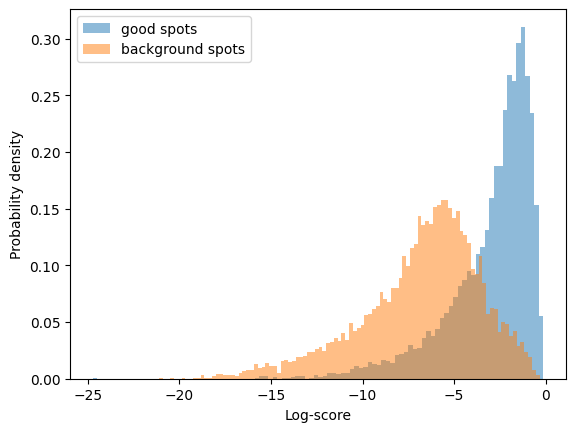

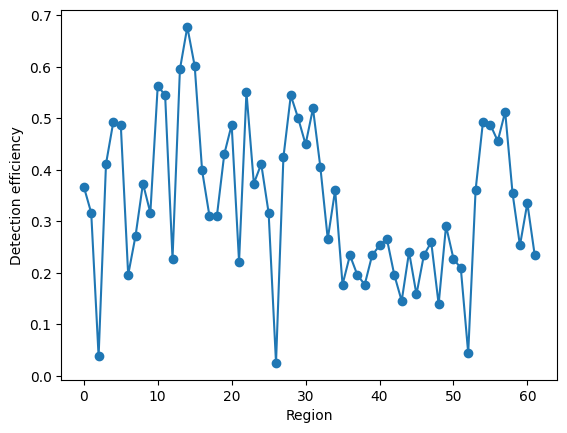

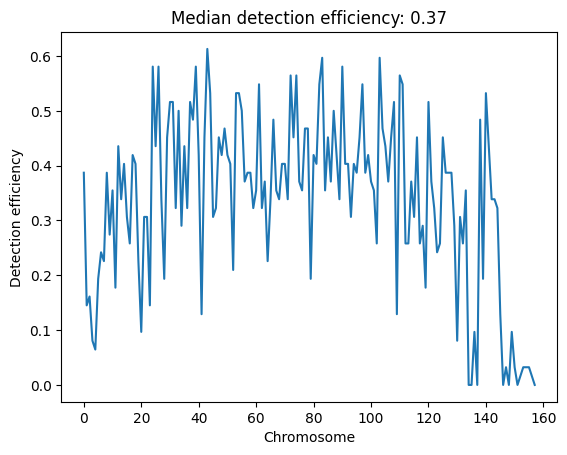

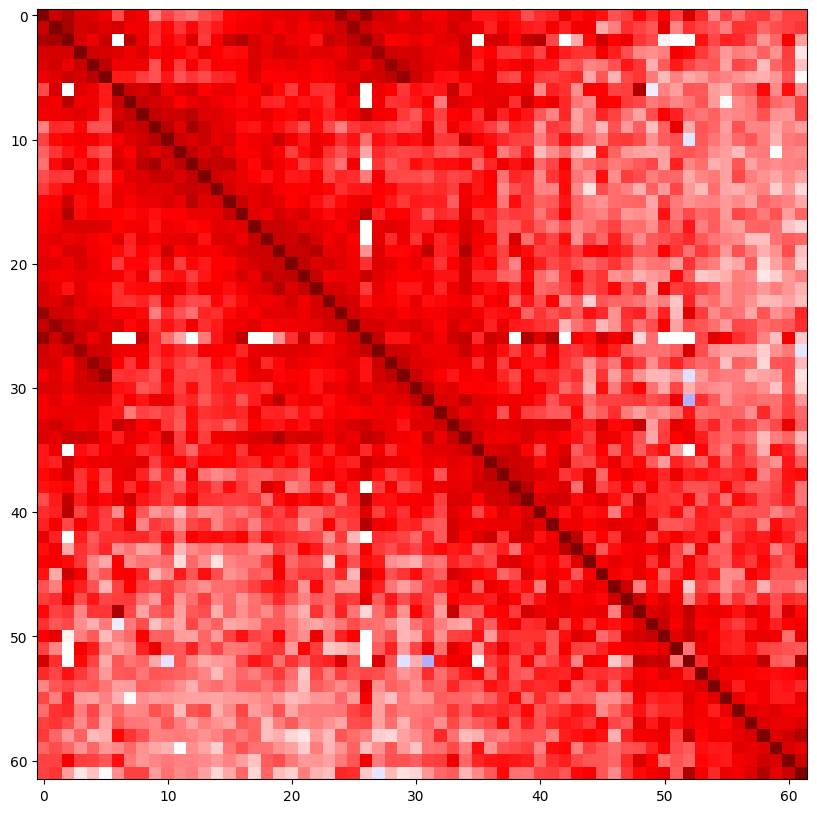

In [9]:
XH_fs = np.load(cp.save_fl)['XH_fs']
Rs = XH_fs[:,-2]
XH_fs=XH_fs[Rs>=0]
get_X_cands(cp,keep_best_per_cell_fast(XH_fs,20),nchr_=3,pix=[0.300,0.1083,0.1083],
                     radius_chr = 2.,radius_cand =2,fr_th=0.35,nelems=2,plt_val = False)
Rs = np.unique(XH_fs[:,-2])
uRs = np.arange(np.max(Rs)+1).astype(int)#np.unique(Rs).astype(int)
initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
normalize_color_brightnesses(cp)
run_EM(cp,nkeep = 80000,niter = 4,Rs_u = uRs)
get_scores_and_threshold(cp,th_score = -2.5)
plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1.5)
plt.show()

cells = cp.icell_cands
ifov = get_fov(cp.save_fl)
cells_f = np.array(cells)+ifov*10**5

In [7]:
save_fls = glob.glob(r'W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CGBogdanV\best_per_cell_SF_all\*__XHfs_finedrft.npz')

In [8]:
save_fls = list(cp.completed_fovs)
len(save_fls)

167

In [56]:
import ioMicroPostFits as pf
import importlib
importlib.reload(pf)

<module 'ioMicroPostFits' from 'C:\\Users\\cfg001\\Desktop\\WTC11\\ioMicroPostFits.py'>

In [70]:
show=False
for cp.ifov in tqdm(cp.completed_fovs):
    cp.set_ = ''
    fls = cp.dic_fls[cp.ifov]
    fls = reorder_on_R(fls,"B")
    cp.fov = get_fullfov(fls[0])
    save_fld_cell = cp.save_folder + os.sep + 'best_per_cell_SF_all'
    cp.save_fl = save_fld_cell + os.sep + cp.fov + '--' + cp.set_ + '__XHfs_finedrft.npz'
    save_fl = cp.save_fl
    save_flf = save_fl.replace('.npz', '_save.npz')
    
    if os.path.exists(save_flf):
        print("already exists, skipping file")
        continue

    XH_fs = np.load(save_fl)['XH_fs']
    print(XH_fs[0])
    iRs = XH_fs[:, -2].astype(int)
    print(iRs)
    get_X_cands(cp, keep_best_per_cell(XH_fs, 8), nchr_=3, pix=[0.200, 0.1083, 0.1083],
                radius_chr=2, radius_cand=2, fr_th=0.4, nelems=4, plt_val=False)

    uRs = np.unique(XH_fs[:, -2], axis=-1).astype(int)
    print(len(np.unique(uRs)))
    initialize_with_max_brightness(cp, nkeep=8000, Rs_u=uRs)

    pf.normalize_color_brightnesses(cp)

    run_EM(cp, nkeep=80000, niter=4, Rs_u=uRs)

    get_scores_and_threshold(cp, th_score=-2.5)
    plot_matrix(cp, th_score=-2.5, lazy_color_correction=True, vmin=0, vmax=0.8)
    if show:
        plt.show()
    
    cells = cp.icell_cands
    ifov = get_fov(save_fl)
    cells_f = np.array(cells) + ifov * 10**5
    np.savez(save_flf, zxys_f=cp.zxys_f, hs_f=cp.hs_f, cells_f=cells_f, scores_f=cp.scores_f)

  0%|                                                                                       | 0/167 [00:00<?, ?it/s]

[ 1.33813763e+01  4.97004013e+01  3.86703400e+02 -4.95392871e+03
  6.15830898e-01  2.49984229e+03  6.98651969e-01  1.65705352e+04
  1.00000000e+00 -2.00000000e+00  1.00000000e+00]
[-2 -2 -2 ... -2 -2 -2]



100%|████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 4646.16it/s]


Detected number of chromosomes:170
Number of cells with 1 chromosomes: 12
Number of cells with 2 chromosomes: 43
Number of cells with 3 chromosomes: 24
1



  0%|                                                                                       | 0/167 [00:00<?, ?it/s]

[[ 4.58602142e+00  1.04370390e+01  4.25821368e+01  3.10049453e+04
   3.10049453e+04  1.00000000e+00 -2.00000000e+00]
 [ 3.78186798e+00  1.04724535e+01  4.26456897e+01  3.12154023e+04
   3.12154023e+04  1.00000000e+00 -2.00000000e+00]
 [ 4.44899521e+00  1.03558082e+01  4.25453516e+01  3.25982969e+04
   3.25982969e+04  1.00000000e+00 -2.00000000e+00]
 [ 3.57950516e+00  1.02801936e+01  4.24762033e+01  3.28992422e+04
   3.28992422e+04  1.00000000e+00 -2.00000000e+00]
 [ 3.64182281e+00  1.03682319e+01  4.25527219e+01  3.60380391e+04
   3.60380391e+04  1.00000000e+00 -2.00000000e+00]] (5, 7)
[[ 1.71452484e+00  4.44655853e+00  4.13657779e+01  3.61255703e+04
   3.61255703e+04  1.00000000e+00 -2.00000000e+00]
 [ 1.86973915e+00  4.55261729e+00  4.14606594e+01  4.24908398e+04
   4.24908398e+04  1.00000000e+00 -2.00000000e+00]] (2, 7)
[[ 4.48886299e+00  1.29517073e+01  5.11727944e+01  2.79921270e+04
   2.79921270e+04  1.00000000e+00 -2.00000000e+00]
 [ 4.33816910e+00  1.28544032e+01  5.10840008e+0

IndexError: index 1 is out of bounds for axis 0 with size 1

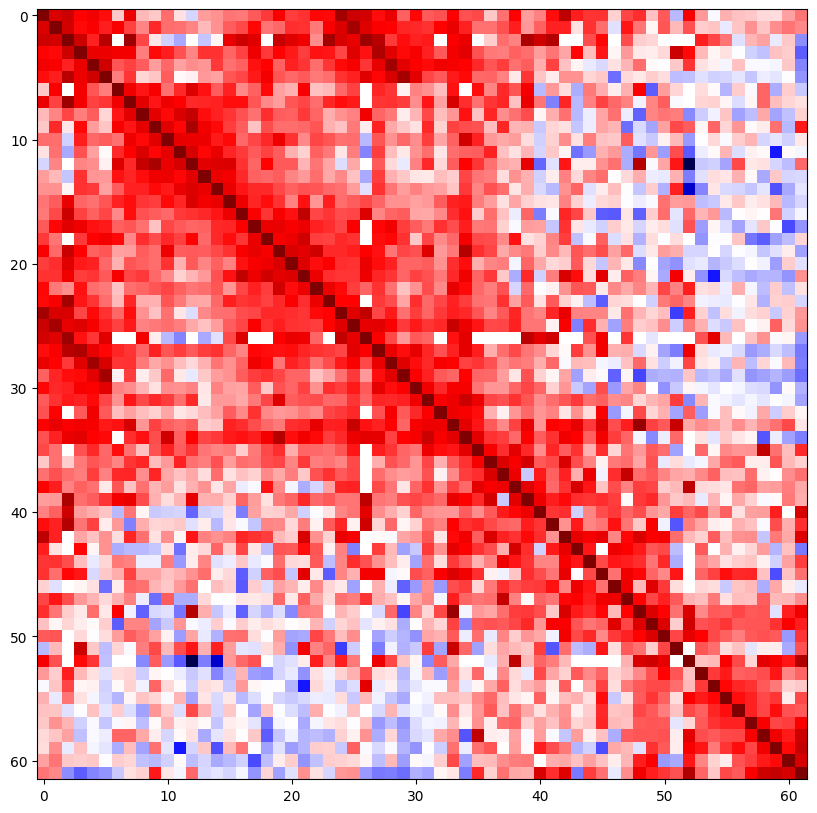

In [14]:
plot_matrix(cp,th_score=-2,lazy_color_correction = True,vmin=0,vmax=1)

In [ ]:
https://drive.google.com/drive/folders/1pO1L866cbOMdF5gLrWS7WA8D8XiowJkE

### Run across all fovs

In [16]:
ifovs_all = list(cp.completed_fovs)
for ifov in tqdm(ifovs_all):
    try:
        main_func(ifov)
    except:
        print("Failed",ifov)

  2%|█▉                                                                                | 4/167 [00:05<04:26,  1.64s/it]

Computing/Loading drift...
Maximum drift: [0.73667246 8.865762   8.436303  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:18<00:00,  2.19s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  3%|██▍                                                                             | 5/167 [02:37<2:30:28, 55.73s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__004--__XHfs_finedrft.npz


  4%|██▊                                                                             | 6/167 [02:39<1:40:51, 37.59s/it]

Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:48<00:00,  4.95s/it]


Maximum drift: [0.6053173 8.868     9.020861 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:03<00:00,  2.92s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  4%|███▎                                                                           | 7/167 [07:46<5:34:53, 125.58s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__006--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.16s/it]


Maximum drift: [0.63619196 7.927885   8.928569  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:12<00:00,  2.10s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  5%|███▊                                                                           | 8/167 [12:05<7:25:19, 168.05s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__007--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:46<00:00,  4.86s/it]


Maximum drift: [0.75052214 7.370117   9.078533  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:26<00:00,  3.28s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  5%|████▎                                                                          | 9/167 [17:40<9:40:02, 220.27s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__008--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:35<00:00,  4.33s/it]


Maximum drift: [0.5544601 7.4806647 8.45497  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:11<00:00,  3.04s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  6%|████▌                                                                        | 10/167 [22:37<10:38:47, 244.12s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__009--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.28s/it]


Maximum drift: [0.3976636 6.9873347 7.9001555]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:01<00:00,  2.89s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  7%|█████                                                                        | 11/167 [27:50<11:29:25, 265.16s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__010--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.42s/it]


Maximum drift: [0.6454959 7.9376206 8.116466 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:50<00:00,  3.66s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  7%|█████▌                                                                       | 12/167 [33:58<12:45:47, 296.43s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__011--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:51<00:00,  5.07s/it]


Maximum drift: [0.62742466 7.673355   8.505063  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:12<00:00,  2.10s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  8%|█████▉                                                                       | 13/167 [38:14<12:09:16, 284.13s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__012--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:10<00:00,  5.93s/it]


Maximum drift: [0.53893226 6.905524   8.079767  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:51<00:00,  2.72s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  8%|██████▍                                                                      | 14/167 [43:30<12:28:45, 293.63s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__013--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.44s/it]


Maximum drift: [0.5524495 6.454693  8.523031 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:47<00:00,  2.66s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


  9%|██████▉                                                                      | 15/167 [48:30<12:28:57, 295.64s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__014--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.42s/it]


Maximum drift: [0.58975095 9.425313   9.310104  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:57<00:00,  1.86s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 10%|███████▍                                                                     | 16/167 [52:38<11:47:57, 281.31s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__015--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:51<00:00,  5.05s/it]


Maximum drift: [ 0.703023 10.293473  9.111551]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:12<00:00,  2.10s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 10%|███████▊                                                                     | 17/167 [56:53<11:23:48, 273.53s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__016--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.21s/it]


Maximum drift: [ 0.59786904 10.55002     8.561181  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:51<00:00,  3.67s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 11%|████████                                                                   | 18/167 [1:03:00<12:28:37, 301.46s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__017--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:48<00:00,  4.92s/it]


Maximum drift: [0.62983686 9.2130785  8.962298  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:04<00:00,  1.97s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 11%|████████▌                                                                  | 19/167 [1:07:09<11:44:47, 285.73s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__018--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:41<00:00,  4.62s/it]


Maximum drift: [0.45825946 9.412383   8.302408  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:25<00:00,  2.30s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 12%|████████▉                                                                  | 20/167 [1:11:31<11:22:46, 278.69s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__019--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.62s/it]


Maximum drift: [0.6831917 8.816815  8.139881 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:25<00:00,  2.31s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 13%|█████████▍                                                                 | 21/167 [1:16:15<11:22:07, 280.32s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__020--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:51<00:00,  5.05s/it]


Maximum drift: [0.5697728 9.095688  8.2434025]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:08<00:00,  2.04s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 13%|█████████▉                                                                 | 22/167 [1:20:31<10:59:11, 272.77s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__021--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:00<00:00,  5.50s/it]


Maximum drift: [0.52358717 8.757331   7.4981413 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:07<00:00,  2.02s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 14%|██████████▎                                                                | 23/167 [1:24:52<10:46:32, 269.39s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__022--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:49<00:00,  4.98s/it]


Maximum drift: [0.59901375 6.429446   7.812694  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:02<00:00,  1.95s/it]


Loading segmentation...


 14%|██████████▊                                                                | 24/167 [1:28:53<10:21:50, 260.91s/it]

Failed 23
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:02<00:00,  5.58s/it]


Maximum drift: [0.72022784 5.659259   7.9069123 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:11<00:00,  3.04s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 15%|███████████▏                                                               | 25/167 [1:34:28<11:09:46, 283.00s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__024--__XHfs_finedrft.npz


 20%|███████████████▌                                                               | 33/167 [1:34:36<38:09, 17.09s/it]

Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.16s/it]


Maximum drift: [0.6341519 9.479056  6.741536 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:19<00:00,  2.22s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 20%|███████████████▋                                                             | 34/167 [1:38:59<3:22:02, 91.14s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__033--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.77s/it]


Maximum drift: [ 0.6568489 10.257736   6.957554 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:57<00:00,  1.87s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 21%|███████████████▉                                                            | 35/167 [1:42:53<4:54:21, 133.80s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__034--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:38<00:00,  4.46s/it]


Maximum drift: [0.71760136 9.657797   7.436465  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:44<00:00,  1.66s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 22%|████████████████▍                                                           | 36/167 [1:46:27<5:44:56, 157.99s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__035--__XHfs_finedrft.npz


 22%|████████████████▊                                                           | 37/167 [1:46:29<4:00:52, 111.17s/it]

Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.55s/it]


Maximum drift: [ 0.49147058 10.6052885   7.4165673 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:25<00:00,  1.36s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 23%|█████████████████▎                                                          | 38/167 [1:49:41<4:51:03, 135.38s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__037--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:11<00:00,  3.26s/it]


Maximum drift: [ 0.6306092 13.439911   7.071673 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:42<00:00,  1.62s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 23%|█████████████████▋                                                          | 39/167 [1:52:53<5:25:01, 152.35s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__038--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:28<00:00,  4.02s/it]


Maximum drift: [ 0.65313447 12.999235    8.303749  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:38<00:00,  1.56s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 24%|██████████████████▏                                                         | 40/167 [1:56:11<5:51:29, 166.06s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__039--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:37<00:00,  4.43s/it]


Maximum drift: [ 0.72411543 12.4724045   7.9206285 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:08<00:00,  2.04s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 25%|██████████████████▋                                                         | 41/167 [2:00:09<6:34:05, 187.67s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__040--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.75s/it]


Maximum drift: [ 0.701796  12.642604   7.2233577]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:20<00:00,  1.27s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 25%|███████████████████                                                         | 42/167 [2:03:27<6:37:35, 190.85s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__041--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.59s/it]


Maximum drift: [ 0.71997863 11.625663    7.2669573 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:49<00:00,  1.74s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 26%|███████████████████▌                                                        | 43/167 [2:07:06<6:51:37, 199.17s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__042--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.91s/it]


Maximum drift: [ 0.81353056 11.306107    7.262682  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:28<00:00,  1.41s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 26%|████████████████████                                                        | 44/167 [2:10:38<6:56:16, 203.06s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__043--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.77s/it]


Maximum drift: [ 0.7274479 10.745307   7.927081 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:45<00:00,  1.68s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 27%|████████████████████▍                                                       | 45/167 [2:14:21<7:04:54, 208.97s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__044--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:39<00:00,  4.50s/it]


Maximum drift: [ 0.67529035 10.888348    8.348681  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:47<00:00,  1.71s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 28%|████████████████████▉                                                       | 46/167 [2:17:55<7:04:39, 210.57s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__045--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:38<00:00,  4.47s/it]


Maximum drift: [ 0.52613586 11.04134     8.179076  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:53<00:00,  1.80s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 28%|█████████████████████▍                                                      | 47/167 [2:21:41<7:10:27, 215.23s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__046--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.59s/it]


Maximum drift: [ 0.57246774 10.40663     8.046732  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:35<00:00,  1.52s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 29%|█████████████████████▊                                                      | 48/167 [2:25:10<7:03:04, 213.32s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__047--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:45<00:00,  4.79s/it]


Maximum drift: [ 0.83265847 10.591492    7.891806  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:26<00:00,  3.28s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 29%|██████████████████████▎                                                     | 49/167 [2:30:39<8:07:43, 248.00s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__048--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.74s/it]


Maximum drift: [0.65281296 8.669168   7.657185  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:34<00:00,  1.50s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 30%|██████████████████████▊                                                     | 50/167 [2:34:09<7:41:08, 236.48s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__049--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:47<00:00,  4.90s/it]


Maximum drift: [0.73400986 7.989097   7.6489477 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:54<00:00,  1.82s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 31%|███████████████████████▏                                                    | 51/167 [2:38:06<7:37:27, 236.61s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__050--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:41<00:00,  4.61s/it]


Maximum drift: [5.76642   8.583827  7.2680135]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:11<00:00,  3.99s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 31%|███████████████████████▋                                                    | 52/167 [2:44:18<8:51:34, 277.34s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__051--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.75s/it]


Maximum drift: [0.84372914 8.201592   7.245223  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:54<00:00,  1.81s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 32%|████████████████████████                                                    | 53/167 [2:48:12<8:22:25, 264.44s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__052--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:42<00:00,  4.66s/it]


Maximum drift: [0.6431734 9.665622  7.4634113]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:12<00:00,  2.11s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 32%|████████████████████████▌                                                   | 54/167 [2:52:15<8:05:32, 257.81s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__053--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.21s/it]


Maximum drift: [0.7183651 9.431942  6.9221945]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:16<00:00,  2.16s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 33%|█████████████████████████                                                   | 55/167 [2:56:41<8:06:18, 260.52s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__054--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.26s/it]


Maximum drift: [0.54906553 8.311173   7.6385317 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:10<00:00,  2.07s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 34%|█████████████████████████▍                                                  | 56/167 [3:01:05<8:03:50, 261.54s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__055--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.41s/it]


Maximum drift: [0.63896316 7.7418203  7.6478148 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:58<00:00,  2.83s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 34%|█████████████████████████▉                                                  | 57/167 [3:06:18<8:27:23, 276.76s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__056--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:58<00:00,  5.40s/it]


Maximum drift: [0.7070853 7.148768  7.299658 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:20<00:00,  4.14s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 35%|██████████████████████████▍                                                 | 58/167 [3:12:55<9:28:13, 312.79s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__057--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:20<00:00,  6.38s/it]


Maximum drift: [0.5902918 7.428427  7.2821965]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:51<00:00,  2.73s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 35%|██████████████████████████▊                                                 | 59/167 [3:18:24<9:31:56, 317.75s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__058--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:01<00:00,  5.52s/it]


Maximum drift: [0.79450434 7.6834464  7.5106535 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:32<00:00,  2.42s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 36%|███████████████████████████▎                                                | 60/167 [3:23:12<9:10:43, 308.82s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__059--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.66s/it]


Maximum drift: [0.7590139 6.768824  7.613275 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:12<00:00,  2.10s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 37%|███████████████████████████▊                                                | 61/167 [3:27:44<8:46:18, 297.91s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__060--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.15s/it]


Maximum drift: [0.6736348 5.844334  7.829342 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:59<00:00,  2.86s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 37%|████████████████████████████▏                                               | 62/167 [3:32:55<8:47:55, 301.67s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__061--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:46<00:00,  4.83s/it]


Maximum drift: [0.6930374 5.244574  7.849202 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:44<00:00,  3.57s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 38%|████████████████████████████▋                                               | 63/167 [3:38:45<9:08:25, 316.40s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__062--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:42<00:00,  4.64s/it]


Maximum drift: [0.60846376 5.918138   8.025241  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:33<00:00,  2.44s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 38%|█████████████████████████████▏                                              | 64/167 [3:43:18<8:40:26, 303.17s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__063--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.74s/it]


Maximum drift: [0.65506756 5.15266    7.874844  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:44<00:00,  3.56s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 39%|█████████████████████████████▌                                              | 65/167 [3:49:04<8:57:15, 316.03s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__064--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:43<00:00,  4.71s/it]


Maximum drift: [0.6550914 6.6139297 7.881171 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:53<00:00,  1.80s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 40%|██████████████████████████████                                              | 66/167 [3:52:55<8:09:09, 290.59s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__065--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.58s/it]


Maximum drift: [0.6135283 7.731233  7.267516 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:30<00:00,  1.44s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 40%|██████████████████████████████▍                                             | 67/167 [3:56:21<7:21:47, 265.08s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__066--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:38<00:00,  4.47s/it]


Maximum drift: [0.62100184 8.098449   7.8433967 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:35<00:00,  1.51s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 41%|██████████████████████████████▉                                             | 68/167 [3:59:49<6:49:28, 248.17s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__067--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:27<00:00,  3.98s/it]


Maximum drift: [0.7196745 7.728808  7.7301416]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:00<00:00,  2.87s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 41%|███████████████████████████████▍                                            | 69/167 [4:04:32<7:02:18, 258.55s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__068--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:34<00:00,  4.30s/it]


Maximum drift: [   4.633053 1850.134    1554.3331  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:44<00:00,  1.66s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 42%|███████████████████████████████▊                                            | 70/167 [4:08:03<6:34:44, 244.17s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__069--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:24<00:00,  3.86s/it]


Maximum drift: [0.603577  6.312559  7.1719723]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:45<00:00,  1.68s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 43%|████████████████████████████████▎                                           | 71/167 [4:11:24<6:10:16, 231.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__070--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:31<00:00,  4.14s/it]


Maximum drift: [2.1361933 6.2508564 7.249586 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:52<00:00,  1.78s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 43%|████████████████████████████████▊                                           | 72/167 [4:14:54<5:56:05, 224.90s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__071--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.76s/it]


Maximum drift: [0.5819379 6.8948874 7.1257253]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:25<00:00,  1.36s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 44%|█████████████████████████████████▏                                          | 73/167 [4:18:15<5:40:52, 217.58s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__072--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:39<00:00,  4.52s/it]


Maximum drift: [0.6832632 6.983116  7.9566636]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:40<00:00,  4.45s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 44%|█████████████████████████████████▋                                          | 74/167 [4:24:55<7:02:15, 272.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__073--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:31<00:00,  4.18s/it]


Maximum drift: [0.48724255 6.30917    7.9107494 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:15<00:00,  3.11s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 45%|██████████████████████████████████▏                                         | 75/167 [4:30:06<7:15:38, 284.12s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__074--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:39<00:00,  4.50s/it]


Maximum drift: [0.7200416 5.3894553 8.05378  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:36<00:00,  1.53s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 46%|██████████████████████████████████▌                                         | 76/167 [4:33:31<6:34:46, 260.29s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__075--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:33<00:00,  4.23s/it]


Maximum drift: [0.6678933 6.125676  8.196032 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:29<00:00,  2.37s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 46%|███████████████████████████████████                                         | 77/167 [4:37:49<6:29:14, 259.49s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__076--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:27<00:00,  3.96s/it]


Maximum drift: [0.6786641 5.971113  8.237173 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:09<00:00,  2.06s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 47%|███████████████████████████████████▍                                        | 78/167 [4:41:34<6:09:40, 249.22s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__077--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:39<00:00,  4.54s/it]


Maximum drift: [0.60313153 5.596494   7.411249  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:55<00:00,  1.83s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 47%|███████████████████████████████████▉                                        | 79/167 [4:45:24<5:57:10, 243.53s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__078--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:40<00:00,  4.56s/it]


Maximum drift: [0.62060195 6.4183674  7.336423  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:50<00:00,  1.75s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 48%|████████████████████████████████████▍                                       | 80/167 [4:49:03<5:42:16, 236.06s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__079--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:37<00:00,  4.45s/it]


Maximum drift: [0.5896986 6.428057  7.6356764]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:04<00:00,  1.98s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 49%|████████████████████████████████████▊                                       | 81/167 [4:53:00<5:38:39, 236.27s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__080--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:46<00:00,  4.83s/it]


Maximum drift: [0.79427177 6.3358154  7.418784  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:26<00:00,  2.33s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 49%|█████████████████████████████████████▎                                      | 82/167 [4:57:29<5:48:48, 246.22s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__081--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:44<00:00,  4.73s/it]


Maximum drift: [0.7608792 6.4667892 7.119786 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:40<00:00,  4.44s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 50%|█████████████████████████████████████▊                                      | 83/167 [5:04:21<6:54:26, 296.02s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__082--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:57<00:00,  5.33s/it]


Maximum drift: [0.64295447 6.9731736  7.855857  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:26<00:00,  2.33s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 50%|██████████████████████████████████████▏                                     | 84/167 [5:09:10<6:46:24, 293.79s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__083--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:45<00:00,  4.79s/it]


Maximum drift: [0.6975688 6.143885  7.9314713]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:19<00:00,  3.17s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 51%|██████████████████████████████████████▋                                     | 85/167 [5:14:38<6:55:25, 303.97s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__084--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:19<00:00,  6.36s/it]


Maximum drift: [0.7622823 5.9222417 7.8158617]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:46<00:00,  2.65s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 51%|███████████████████████████████████████▏                                    | 86/167 [5:19:58<6:57:05, 308.95s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__085--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.44s/it]


Maximum drift: [0.6173843 5.5372286 7.1251354]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:49<00:00,  2.68s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 52%|███████████████████████████████████████▌                                    | 87/167 [5:25:03<6:50:17, 307.72s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__086--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:08<00:00,  5.83s/it]


Maximum drift: [0.7304178 5.342786  7.2927766]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:34<00:00,  2.45s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 53%|████████████████████████████████████████                                    | 88/167 [5:29:58<6:40:13, 303.96s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__087--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:46<00:00,  4.85s/it]


Maximum drift: [0.70302474 5.539055   7.797035  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:42<00:00,  3.54s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 53%|████████████████████████████████████████▌                                   | 89/167 [5:35:43<6:51:04, 316.22s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__088--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:02<00:00,  5.56s/it]


Maximum drift: [0.68326956 6.215271   7.9354033 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:09<00:00,  2.06s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 54%|████████████████████████████████████████▉                                   | 90/167 [5:40:15<6:28:42, 302.89s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__089--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:15<00:00,  6.17s/it]


Maximum drift: [0.7749744 6.720589  7.47292  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:48<00:00,  2.68s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 54%|█████████████████████████████████████████▍                                  | 91/167 [5:45:39<6:31:42, 309.24s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__090--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:24<00:00,  6.55s/it]


Maximum drift: [4.7255883 8.364588  7.226937 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:13<00:00,  3.07s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 55%|█████████████████████████████████████████▊                                  | 92/167 [5:51:34<6:43:42, 322.97s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__091--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:16<00:00,  6.21s/it]


Maximum drift: [0.44999927 8.596833   7.1905985 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:59<00:00,  2.85s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 56%|██████████████████████████████████████████▎                                 | 93/167 [5:57:04<6:41:08, 325.25s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__092--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.43s/it]


Maximum drift: [0.64075524 8.774707   6.695763  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:10<00:00,  3.02s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 56%|██████████████████████████████████████████▊                                 | 94/167 [6:02:33<6:36:47, 326.12s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__093--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:05<00:00,  5.72s/it]


Maximum drift: [0.6271781 8.543218  6.3455663]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:07<00:00,  3.93s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 57%|███████████████████████████████████████████▏                                | 95/167 [6:09:01<6:53:42, 344.76s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__094--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.21s/it]


Maximum drift: [0.6659751 5.892034  6.352055 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:34<00:00,  2.46s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 57%|███████████████████████████████████████████▋                                | 96/167 [6:13:41<6:25:04, 325.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__095--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.31s/it]


Maximum drift: [0.7249459 6.2237806 6.7175527]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:59<00:00,  2.85s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 58%|████████████████████████████████████████████▏                               | 97/167 [6:18:50<6:14:00, 320.57s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__096--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:58<00:00,  5.39s/it]


Maximum drift: [0.62151444 7.055295   6.92644   ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:58<00:00,  2.83s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 59%|████████████████████████████████████████████▌                               | 98/167 [6:23:57<6:03:53, 316.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__097--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.26s/it]


Maximum drift: [0.5615694 8.589737  6.8394794]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.51s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 59%|█████████████████████████████████████████████                               | 99/167 [6:28:47<5:49:28, 308.36s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__098--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:59<00:00,  5.44s/it]


Maximum drift: [0.6926995 8.883336  6.7493706]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:46<00:00,  2.64s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 60%|████████████████████████████████████████████▉                              | 100/167 [6:33:49<5:42:15, 306.49s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__099--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:06<00:00,  5.75s/it]


Maximum drift: [0.618667  8.4595995 7.108779 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:37<00:00,  2.50s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 60%|█████████████████████████████████████████████▎                             | 101/167 [6:38:52<5:36:00, 305.46s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__100--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:06<00:00,  5.73s/it]


Maximum drift: [0.6886262 7.545231  7.1741276]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:37<00:00,  2.50s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 61%|█████████████████████████████████████████████▊                             | 102/167 [6:43:43<5:26:19, 301.23s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__101--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:50<00:00,  5.02s/it]


Maximum drift: [0.6488821 7.3062973 7.0383167]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:07<00:00,  2.03s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 62%|██████████████████████████████████████████████▎                            | 103/167 [6:47:57<5:05:59, 286.86s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__102--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:06<00:00,  5.76s/it]


Maximum drift: [0.51605445 6.834205   7.1773276 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 62%|██████████████████████████████████████████████▋                            | 104/167 [6:52:59<5:06:10, 291.60s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__103--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:02<00:00,  5.57s/it]


Maximum drift: [4.089037  7.0945053 7.041849 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:02<00:00,  1.94s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 63%|███████████████████████████████████████████████▏                           | 105/167 [6:57:20<4:51:48, 282.40s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__104--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:12<00:00,  6.02s/it]


Maximum drift: [0.39081606 6.51388    7.147424  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:15<00:00,  2.16s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 63%|███████████████████████████████████████████████▌                           | 106/167 [7:02:01<4:46:43, 282.02s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__105--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:01<00:00,  5.51s/it]


Maximum drift: [0.7542474 7.0391808 6.2155066]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.59s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 64%|████████████████████████████████████████████████                           | 107/167 [7:07:03<4:47:50, 287.84s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__106--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.18s/it]


Maximum drift: [4.7102785 7.691667  5.8680143]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:08<00:00,  3.00s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 65%|████████████████████████████████████████████████▌                          | 108/167 [7:12:18<4:51:05, 296.03s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__107--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:52<00:00,  5.13s/it]


Maximum drift: [0.8133345 7.690245  7.366547 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:04<00:00,  2.92s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 65%|████████████████████████████████████████████████▉                          | 109/167 [7:17:27<4:49:58, 299.98s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__108--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.59s/it]


Maximum drift: [0.6713751 7.2455864 6.6700835]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:29<00:00,  2.37s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 66%|█████████████████████████████████████████████████▍                         | 110/167 [7:22:12<4:40:46, 295.56s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__109--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.29s/it]


Maximum drift: [0.6334097 7.2418904 6.298533 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:32<00:00,  2.41s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 66%|█████████████████████████████████████████████████▊                         | 111/167 [7:26:51<4:31:07, 290.49s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__110--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.64s/it]


Maximum drift: [0.7730722 7.0639305 7.36689  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:50<00:00,  2.70s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 67%|██████████████████████████████████████████████████▎                        | 112/167 [7:32:03<4:32:17, 297.04s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__111--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:02<00:00,  5.55s/it]


Maximum drift: [0.6500706 6.907598  6.811523 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:14<00:00,  3.09s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 68%|██████████████████████████████████████████████████▋                        | 113/167 [7:37:36<4:36:56, 307.72s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__112--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:07<00:00,  5.82s/it]


Maximum drift: [  9.10846 479.1453  399.96405]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:29<00:00,  2.37s/it]


Loading segmentation...


 68%|███████████████████████████████████████████████████▏                       | 114/167 [7:42:25<4:26:57, 302.22s/it]

Compute drift correction segmentation file...
Keeping best points per cell:80
Failed 113
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:01<00:00,  5.52s/it]


Maximum drift: [0.61100465 6.0018334  6.697229  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [05:57<00:00,  5.67s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 69%|███████████████████████████████████████████████████▋                       | 115/167 [7:50:53<5:15:22, 363.89s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__114--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.66s/it]


Maximum drift: [0.70513666 7.2684712  6.7864585 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:46<00:00,  2.65s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 69%|████████████████████████████████████████████████████                       | 116/167 [7:55:58<4:54:09, 346.07s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__115--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:05<00:00,  5.69s/it]


Maximum drift: [0.75524384 6.014484   6.9345136 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.51s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 70%|████████████████████████████████████████████████████▌                      | 117/167 [8:00:53<4:35:49, 331.00s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__116--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.59s/it]


Maximum drift: [0.5410957 7.0768895 7.0008125]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:13<00:00,  4.03s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 71%|████████████████████████████████████████████████████▉                      | 118/167 [8:07:33<4:47:14, 351.72s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__117--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:12<00:00,  6.01s/it]


Maximum drift: [0.6405272 7.5729327 6.625919 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:15<00:00,  3.11s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 71%|█████████████████████████████████████████████████████▍                     | 119/167 [8:13:20<4:40:06, 350.13s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__118--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:16<00:00,  6.21s/it]


Maximum drift: [0.56505835 7.8392563  6.2396197 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:29<00:00,  3.32s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 72%|█████████████████████████████████████████████████████▉                     | 120/167 [8:19:20<4:36:43, 353.26s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__119--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:10<00:00,  5.92s/it]


Maximum drift: [0.6480179 7.9467707 6.5170956]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:08<00:00,  2.99s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 72%|██████████████████████████████████████████████████████▎                    | 121/167 [8:24:59<4:27:33, 348.98s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__120--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:25<00:00,  6.61s/it]


Maximum drift: [0.7189306 7.2032857 6.8574996]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:00<00:00,  2.87s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 73%|██████████████████████████████████████████████████████▊                    | 122/167 [8:30:45<4:20:52, 347.84s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__121--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:13<00:00,  6.06s/it]


Maximum drift: [0.6059444 6.76926   6.8511777]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:14<00:00,  2.14s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 74%|███████████████████████████████████████████████████████▏                   | 123/167 [8:35:27<4:00:45, 328.30s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__122--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:03<00:00,  5.61s/it]


Maximum drift: [0.6791638 7.008482  6.8840346]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:07<00:00,  2.97s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 74%|███████████████████████████████████████████████████████▋                   | 124/167 [8:40:53<3:54:42, 327.50s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__123--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.29s/it]


Maximum drift: [0.75869143 8.317564   6.7848516 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:32<00:00,  2.41s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 75%|████████████████████████████████████████████████████████▏                  | 125/167 [8:45:37<3:40:05, 314.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__124--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.15s/it]


Maximum drift: [0.72339016 7.964104   6.9189725 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:17<00:00,  2.18s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 75%|████████████████████████████████████████████████████████▌                  | 126/167 [8:50:01<3:24:36, 299.42s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__125--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.15s/it]


Maximum drift: [0.636955  7.6314745 7.124265 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:21<00:00,  2.24s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 76%|█████████████████████████████████████████████████████████                  | 127/167 [8:54:25<3:12:28, 288.71s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__126--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:50<00:00,  5.01s/it]


Maximum drift: [0.7448556 7.1072288 7.22234  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:30<00:00,  2.39s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 77%|█████████████████████████████████████████████████████████▍                 | 128/167 [8:59:06<3:06:12, 286.48s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__127--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:56<00:00,  5.28s/it]


Maximum drift: [0.5918229 7.0985527 6.4750834]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:10<00:00,  2.07s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 77%|█████████████████████████████████████████████████████████▉                 | 129/167 [9:03:26<2:56:22, 278.48s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__128--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:34<00:00,  4.31s/it]


Maximum drift: [0.491088  7.4738636 5.7290177]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:46<00:00,  3.59s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 78%|██████████████████████████████████████████████████████████▍                | 130/167 [9:09:07<3:03:16, 297.20s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__129--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.24s/it]


Maximum drift: [0.64023376 7.102303   6.196101  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:08<00:00,  2.99s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 78%|██████████████████████████████████████████████████████████▊                | 131/167 [9:14:23<3:01:45, 302.93s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__130--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:45<00:00,  4.78s/it]


Maximum drift: [0.6873734 7.0402403 6.2689247]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:00<00:00,  1.91s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 79%|███████████████████████████████████████████████████████████▎               | 132/167 [9:18:27<2:46:24, 285.26s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__131--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.27s/it]


Maximum drift: [0.653993  7.6292486 6.598794 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:37<00:00,  2.51s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 80%|███████████████████████████████████████████████████████████▋               | 133/167 [9:23:12<2:41:31, 285.05s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__132--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.14s/it]


Maximum drift: [0.6742472 7.7877874 6.7288265]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:07<00:00,  2.02s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 80%|████████████████████████████████████████████████████████████▏              | 134/167 [9:27:28<2:31:56, 276.25s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__133--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:01<00:00,  5.54s/it]


Maximum drift: [0.635476  6.9746084 6.3794913]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:43<00:00,  2.60s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 81%|████████████████████████████████████████████████████████████▋              | 135/167 [9:32:25<2:30:44, 282.64s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__134--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.15s/it]


Maximum drift: [0.5903221 7.4048996 6.1909375]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:04<00:00,  1.98s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 81%|█████████████████████████████████████████████████████████████              | 136/167 [9:36:35<2:20:52, 272.67s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__135--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.27s/it]


Maximum drift: [0.6420323 7.1649547 5.7860317]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:50<00:00,  1.75s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 82%|█████████████████████████████████████████████████████████████▌             | 137/167 [9:40:29<2:10:39, 261.33s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__136--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:55<00:00,  5.26s/it]


Maximum drift: [0.7077205 8.59479   6.9401836]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [05:21<00:00,  5.11s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 83%|█████████████████████████████████████████████████████████████▉             | 138/167 [9:48:10<2:35:16, 321.26s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__137--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.16s/it]


Maximum drift: [0.69607466 9.068397   6.3496537 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [01:43<00:00,  1.64s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 83%|██████████████████████████████████████████████████████████████▍            | 139/167 [9:52:01<2:17:08, 293.89s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__138--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:53<00:00,  5.14s/it]


Maximum drift: [0.5478269 8.590146  7.0505466]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:34<00:00,  2.46s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 84%|██████████████████████████████████████████████████████████████▊            | 140/167 [9:56:42<2:10:36, 290.24s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__139--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:57<00:00,  5.32s/it]


Maximum drift: [0.60697466 6.9082747  7.2126203 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:29<00:00,  2.37s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 84%|██████████████████████████████████████████████████████████████▍           | 141/167 [10:01:26<2:04:55, 288.28s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__140--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.64s/it]


Maximum drift: [0.6600922 7.546378  7.1678624]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.55s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 85%|██████████████████████████████████████████████████████████████▉           | 142/167 [10:06:28<2:01:51, 292.46s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__141--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:00<00:00,  5.46s/it]


Maximum drift: [0.6044441 9.219388  7.294096 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:08<00:00,  2.03s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 86%|███████████████████████████████████████████████████████████████▎          | 143/167 [10:10:50<1:53:17, 283.23s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__142--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:37<00:00,  4.45s/it]


Maximum drift: [0.71050155 8.332801   7.645255  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:37<00:00,  2.49s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 86%|███████████████████████████████████████████████████████████████▊          | 144/167 [10:15:23<1:47:23, 280.16s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__143--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:02<00:00,  5.57s/it]


Maximum drift: [   4.9065933 2049.9983     429.76904  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:33<00:00,  2.44s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 87%|████████████████████████████████████████████████████████████████▎         | 145/167 [10:20:18<1:44:20, 284.55s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__144--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:48<00:00,  4.91s/it]


Maximum drift: [0.83384126 6.5016704  6.782923  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:10<00:00,  2.07s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 87%|████████████████████████████████████████████████████████████████▋         | 146/167 [10:24:28<1:36:02, 274.41s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__145--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.22s/it]


Maximum drift: [0.7033282 7.153621  6.972299 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:09<00:00,  2.05s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 88%|█████████████████████████████████████████████████████████████████▏        | 147/167 [10:28:47<1:29:53, 269.66s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__146--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:49<00:00,  4.96s/it]


Maximum drift: [0.7598756 5.9325423 7.3922215]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:09<00:00,  3.96s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 89%|█████████████████████████████████████████████████████████████████▌        | 148/167 [10:35:02<1:35:22, 301.18s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__147--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:00<00:00,  5.48s/it]


Maximum drift: [0.70050865 6.379937   7.168202  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:21<00:00,  2.25s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 89%|██████████████████████████████████████████████████████████████████        | 149/167 [10:39:42<1:28:26, 294.79s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__148--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:07<00:00,  5.81s/it]


Maximum drift: [0.52309555 7.1570277  6.765145  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:49<00:00,  2.69s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 90%|██████████████████████████████████████████████████████████████████▍       | 150/167 [10:44:55<1:25:05, 300.33s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__149--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:19<00:00,  6.36s/it]


Maximum drift: [0.69539076 6.3648396  6.9829326 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.54s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 90%|██████████████████████████████████████████████████████████████████▉       | 151/167 [10:50:08<1:21:05, 304.12s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__150--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.65s/it]


Maximum drift: [0.6864332 6.685477  6.901836 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:45<00:00,  2.63s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 91%|███████████████████████████████████████████████████████████████████▎      | 152/167 [10:55:19<1:16:31, 306.13s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__151--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:05<00:00,  5.69s/it]


Maximum drift: [0.6687677 6.530024  6.806001 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:15<00:00,  2.14s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 92%|███████████████████████████████████████████████████████████████████▊      | 153/167 [10:59:51<1:09:04, 296.01s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__152--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:07<00:00,  5.81s/it]


Maximum drift: [0.627872  5.955298  6.3610244]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:10<00:00,  3.02s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 92%|████████████████████████████████████████████████████████████████████▏     | 154/167 [11:05:24<1:06:31, 307.06s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__153--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:18<00:00,  6.30s/it]


Maximum drift: [0.7240836 5.1593704 7.6710315]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:27<00:00,  2.34s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 93%|████████████████████████████████████████████████████████████████████▋     | 155/167 [11:10:29<1:01:18, 306.51s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__154--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:14<00:00,  6.12s/it]


Maximum drift: [0.65548253 6.0030603  6.706196  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 93%|██████████████████████████████████████████████████████████████████████▉     | 156/167 [11:15:37<56:16, 306.92s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__155--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:18<00:00,  6.29s/it]


Maximum drift: [0.77649814 6.2481575  6.823223  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [04:41<00:00,  4.47s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 94%|███████████████████████████████████████████████████████████████████████▍    | 157/167 [11:22:57<57:47, 346.79s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__156--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:34<00:00,  7.03s/it]


Maximum drift: [0.70178217 6.5462294  7.3995137 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [03:07<00:00,  2.97s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 95%|███████████████████████████████████████████████████████████████████████▉    | 158/167 [11:28:55<52:31, 350.15s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__157--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:15<00:00,  6.14s/it]


Maximum drift: [0.7093324 6.520653  7.4953065]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:52<00:00,  2.75s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 95%|████████████████████████████████████████████████████████████████████████▎   | 159/167 [11:34:15<45:28, 341.08s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__158--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:12<00:00,  6.03s/it]


Maximum drift: [0.57026184 6.2934365  7.056294  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [05:53<00:00,  5.61s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 96%|████████████████████████████████████████████████████████████████████████▊   | 160/167 [11:42:49<45:52, 393.15s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__159--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:11<00:00,  5.96s/it]


Maximum drift: [0.6697798 6.4591293 6.219952 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:35<00:00,  2.46s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 96%|█████████████████████████████████████████████████████████████████████████▎  | 161/167 [11:47:50<36:31, 365.28s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__160--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:10<00:00,  5.95s/it]


Maximum drift: [0.60718316 6.8765187  6.3230433 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:33<00:00,  2.43s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 97%|█████████████████████████████████████████████████████████████████████████▋  | 162/167 [11:52:53<28:54, 346.87s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__161--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:14<00:00,  6.13s/it]


Maximum drift: [0.636397 6.465474 5.998367]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:23<00:00,  2.28s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 98%|██████████████████████████████████████████████████████████████████████████▏ | 163/167 [11:57:48<22:04, 331.05s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__162--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:06<00:00,  5.76s/it]


Maximum drift: [0.6739508 6.3798165 6.687436 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.52s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 98%|██████████████████████████████████████████████████████████████████████████▋ | 164/167 [12:02:49<16:06, 322.11s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__163--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:57<00:00,  5.36s/it]


Maximum drift: [0.6771381 6.1020865 6.401551 ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:55<00:00,  2.78s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 99%|███████████████████████████████████████████████████████████████████████████ | 165/167 [12:07:57<10:35, 317.97s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__164--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [02:04<00:00,  5.68s/it]


Maximum drift: [0.57833624 5.2039275  6.719818  ]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:19<00:00,  2.21s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


 99%|███████████████████████████████████████████████████████████████████████████▌| 166/167 [12:12:38<05:06, 306.86s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__165--__XHfs_finedrft.npz
Computing/Loading drift...



100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.19s/it]


Maximum drift: [0.5279689 5.046663  5.8221693]
Load the fitted data and apply drift correction to dots...



100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [02:35<00:00,  2.47s/it]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80


100%|████████████████████████████████████████████████████████████████████████████| 167/167 [12:17:24<00:00, 264.94s/it]

Saved the augmented fits to file: W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__166--__XHfs_finedrft.npz


In [17]:
1250*4/(51*3)

32.6797385620915

In [28]:
from ioMicroPostFits import *

W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\Conv_zscan__000--__XHfs_finedrft.npz


100%|█████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 637.65it/s]


Detected number of chromosomes:115
Number of cells with 1 chromosomes: 23
Number of cells with 2 chromosomes: 46


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 2613.05it/s]


[12274.42578125 14344.95996094 10454.16699219] (3,)


100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 2613.05it/s]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:104: RuntimeWarning: invalid value encountered in divide
  ret_ = ret[n_ - 1:] / ret_nan[n_ - 1:]


EM iteration number:  1


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 351.60it/s]


fraction the same: 0.9095371669004207
fraction nan: 0.3709677419354839
EM iteration number:  2


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 508.73it/s]


fraction the same: 0.9907433380084152
fraction nan: 0.3709677419354839
EM iteration number:  3


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 547.49it/s]


fraction the same: 0.9984572230014025
fraction nan: 0.3709677419354839
EM iteration number:  4


100%|███████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 550.11it/s]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:833: RuntimeWarning: Mean of empty slice
  cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:835: RuntimeWarning: All-NaN slice encountered
  Xf[:,icol::ncol,:]-=np.nanmedian(Xf[:,icol::ncol,:],axis=1)[:,np.newaxis]+cm
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:842: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmedian(mats[:,keep][:,:,keep],0),vmax=vmax,vmin=vmin,cmap='seismic_r')


fraction the same: 0.9997194950911641
fraction nan: 0.3709677419354839


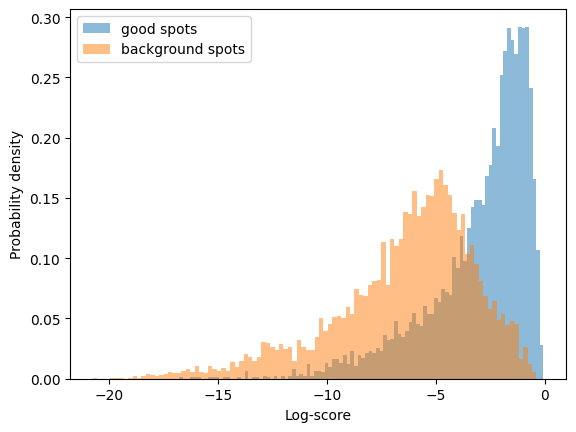

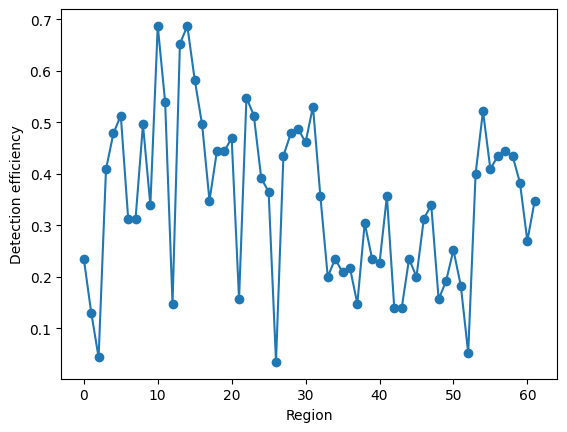

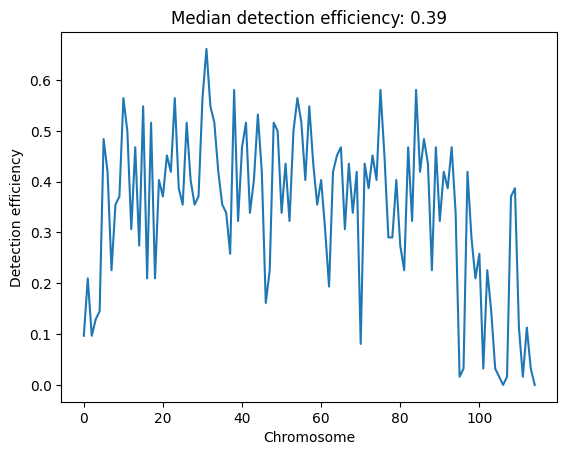

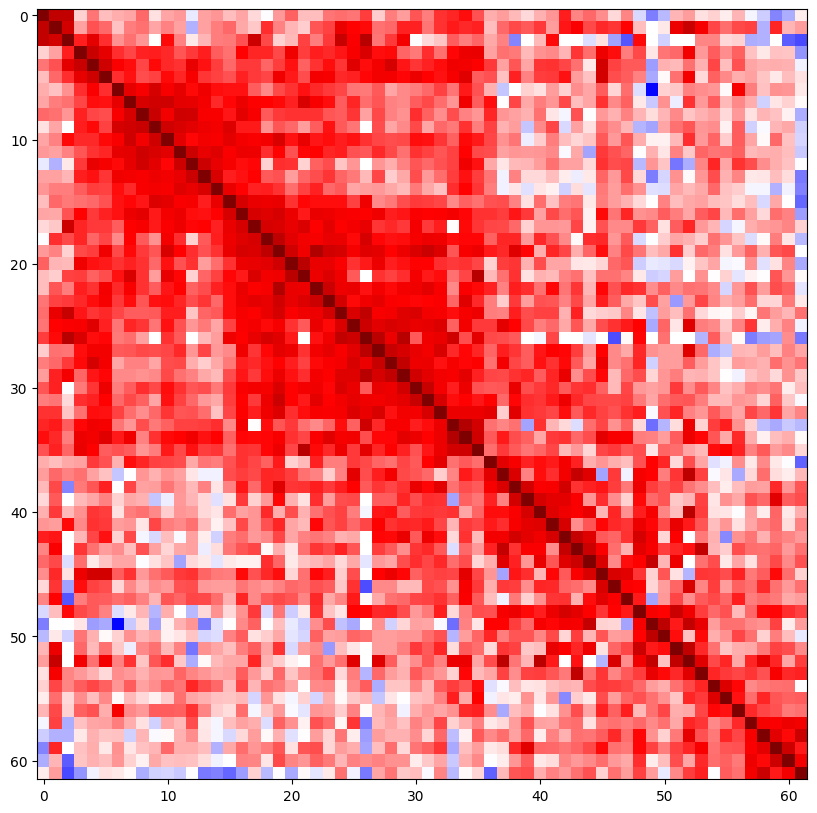

AttributeError: 'chromatin_postfits' object has no attribute 'save_fl'

In [11]:
#Y:\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG
save_fls = glob.glob(r'W:\Adam\E217_WTC11_day14_Rad21_CHATDNA\AnalysisDeconvolve_CG\best_per_cellCFGP2\*__XHfs_finedrft.npz')
for save_fl in save_fls:
    print(save_fl)
    save_flf= save_fl.replace('.npz','_saveV2.npz')
    if not os.path.exists(save_flf):
        XH_fs = np.load(save_fl)['XH_fs']
        Rs = XH_fs[:,-2]
        XH_fs=XH_fs[Rs>=0]
        get_X_cands(cp,keep_best_per_cell_fast(XH_fs,20),nchr_=3,pix=[0.300,0.1083,0.1083],
                             radius_chr = 2.,radius_cand =2,fr_th=0.35,nelems=2,plt_val = False)
        Rs = np.unique(XH_fs[:,-2])
        uRs = np.arange(np.max(Rs)+1).astype(int)#np.unique(Rs).astype(int)
        initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
        normalize_color_brightnesses(cp)
        run_EM(cp,nkeep = 80000,niter = 4,Rs_u = uRs)
        get_scores_and_threshold(cp,th_score = -2.5)
        plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1.5)
        plt.show()
        
        cells = cp.icell_cands
        ifov = get_fov(cp.save_fl)
        cells_f = np.array(cells)+ifov*10**5

In [6]:
XH_fs = np.load(cp.save_fl)['XH_fs']
Rs = XH_fs[:,-2]
XH_fs=XH_fs[Rs>=0]
get_X_cands(cp,keep_best_per_cell_fast(XH_fs,20),nchr_=3,pix=[0.300,0.1083,0.1083],
                         radius_chr = 2.,radius_cand =2,fr_th=0.35,nelems=2,plt_val = False)
Rs = np.unique(XH_fs[:,-2])
uRs = np.arange(np.max(Rs)+1).astype(int)#np.unique(Rs).astype(int)
initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
normalize_color_brightnesses(cp)
ifovs_all = list(cp.completed_fovs)

for ifov in tqdm(ifovs_all):
    try:
        run_EM(ifov)
    except:
        print("Failed",ifov)

AttributeError: 'chromatin_postfits' object has no attribute 'save_fl'

In [18]:
??normalize_color_brightnesses

Signature: normalize_color_brightnesses(self)
Docstring: <no docstring>
Source:   
def normalize_color_brightnesses(self):
    zxys_f,hs_f,hs_bk_f  = self.zxys_f,self.hs_f,self.hs_bk_f
    ### get dic_col
    X_cands = self.X_cands
    dic_col = {}
    for X in X_cands:
        Rs = X[:,-1]
        icols = X[:,-2]
        for R,icol in zip(Rs,icols):
            dic_col[R] = icol
    self.dic_col=dic_col

    cols = np.unique(list(dic_col.values()))

    hmed = np.nanmedian(np.array(hs_f),axis=0)
    #print(Hths)
    Hths = np.array([np.nanmedian(hmed[[list(self.Rs_u).index(R) for R in dic_col if dic_col[R]==icol]])
                     for icol in cols])
    print(Hths, Hths.shape)
    X_cands_ = [X.copy() for X in X_cands]
    for X in X_cands_:
        Rs = X[:,-1]
        icols = X[:,-2].astype(int)
        X[:,3]=X[:,3]/Hths[icols]
    self.X_cands_ = X_cands_
File:      c:\users\cfg001\desktop\wtc11\iomicropostfits.py
Type:      function

In [20]:
cp.dic_fls

{0: array(['Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H21_R52_R53_R54--col0__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H18_R43_R44_R45--col2__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H13_R28_R29_R30--col0__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H12_R25_R26_R27--col1__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H6_R7_R8_R9--col0__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H7_R10_R11_R12--col2__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\\Conv_zscan__000--H4_R1_R2_R3_rep--col1__Xhfits.npz',
        'Y:\\Adam\\One_by_one\\E200_WTC11_WTday3__8_31_2023\\AnalysisDevonvCG\

In [26]:
save_fls = glob.glob(r'Z:\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG\best_per_cellCFGP2\*__XHfs_finedrft.npz')
for save_fl in save_fls:
    print(save_fl)
    #try:
    save_flf= save_fl.replace('.npz','_save.npz')
    if not os.path.exists(save_flf):
        XH_fs = np.load(save_fl)['XH_fs']
        get_X_cands(cp,keep_best_per_cell_fast(XH_fs,20),nchr_=3,pix=[0.300,0.1083,0.1083],
                             radius_chr = 2.,radius_cand =3.5,fr_th=0.35,nelems=2,plt_val = False)

        uRs = np.unique(Rs).astype(int)# np.arange(np.max(Rs)+1).astype(int) #np.unique(Rs).astype(int)
        initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
        normalize_color_brightnesses(cp)
        run_EM(cp,nkeep = 80000,niter = 4,Rs_u = uRs)
        get_scores_and_threshold(cp,th_score = -2.5)
        plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1.5)#,vmin=0,vmax=0.5)
        plt.show()

        cells = cp.icell_cands
        ifov = get_fov(save_fl)
        #cells_f = np.array(cells)+ifov*10**5
        np.savez(save_flf,zxys_f = cp.zxys_f,hs_f = cp.hs_f,cells_f=cells_f,scores_f=cp.scores_f)
        plt.close('all')#####
#except:
    print("Failed",save_fl)

Z:\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG\best_per_cellCFGP2\Conv_zscan__047--__XHfs_finedrft.npz


100%|████████████████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 245.77it/s]


Detected number of chromosomes:883
Number of cells with 1 chromosomes: 253
Number of cells with 2 chromosomes: 285
Number of cells with 3 chromosomes: 20


100%|███████████████████████████████████████████████████████████████████████████| 883/883 [00:00<00:00, 2992.55it/s]


ValueError: -2.0 is not in list

In [13]:
zxys_f

NameError: name 'zxys_f' is not defined

C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:833: RuntimeWarning: Mean of empty slice
  cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:835: RuntimeWarning: All-NaN slice encountered
  Xf[:,icol::ncol,:]-=np.nanmedian(Xf[:,icol::ncol,:],axis=1)[:,np.newaxis]+cm
C:\Users\cfg001\Desktop\WTC11\ioMicroPostFits.py:842: RuntimeWarning: All-NaN slice encountered
  plt.imshow(np.nanmedian(mats[:,keep][:,:,keep],0),vmax=vmax,vmin=vmin,cmap='seismic_r')


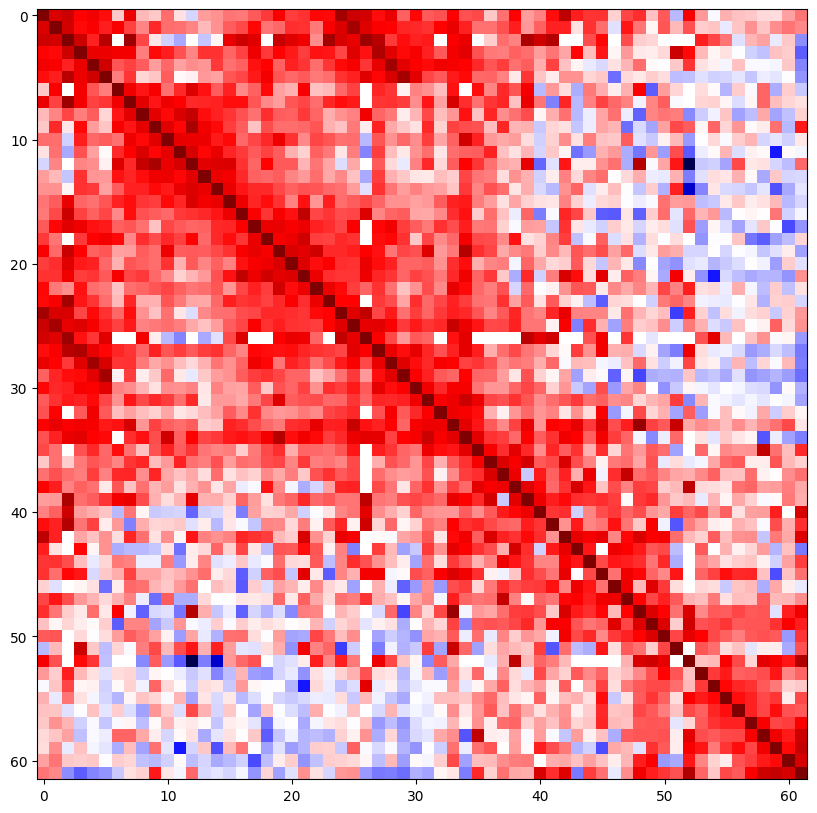

In [19]:
plot_matrix(cp,th_score=-2,lazy_color_correction = True,vmin=0,vmax=1)

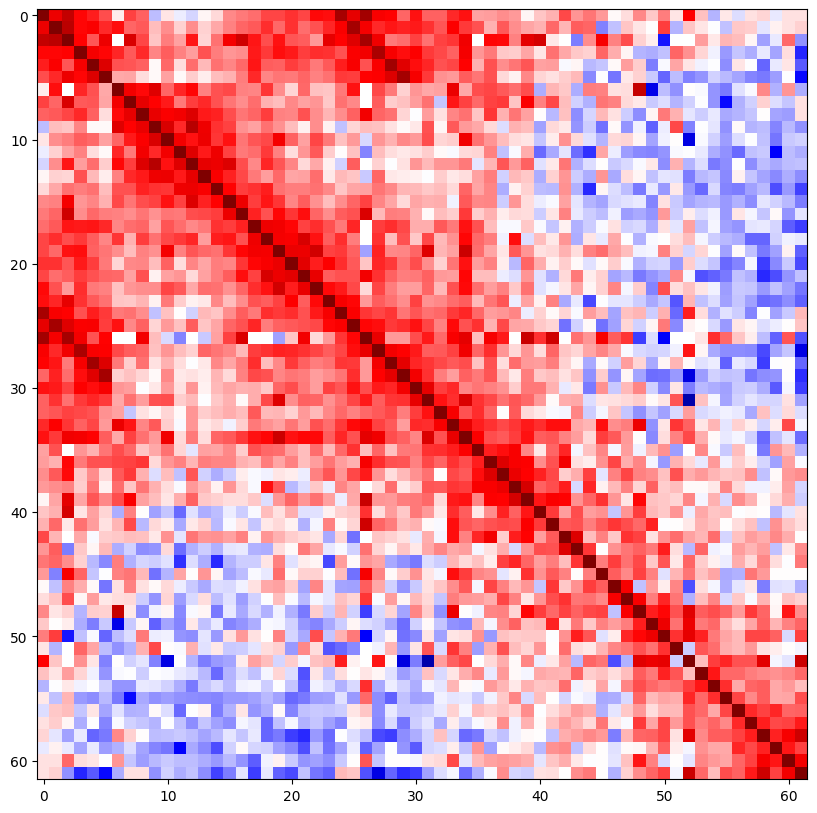

In [20]:
plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1) #try 3

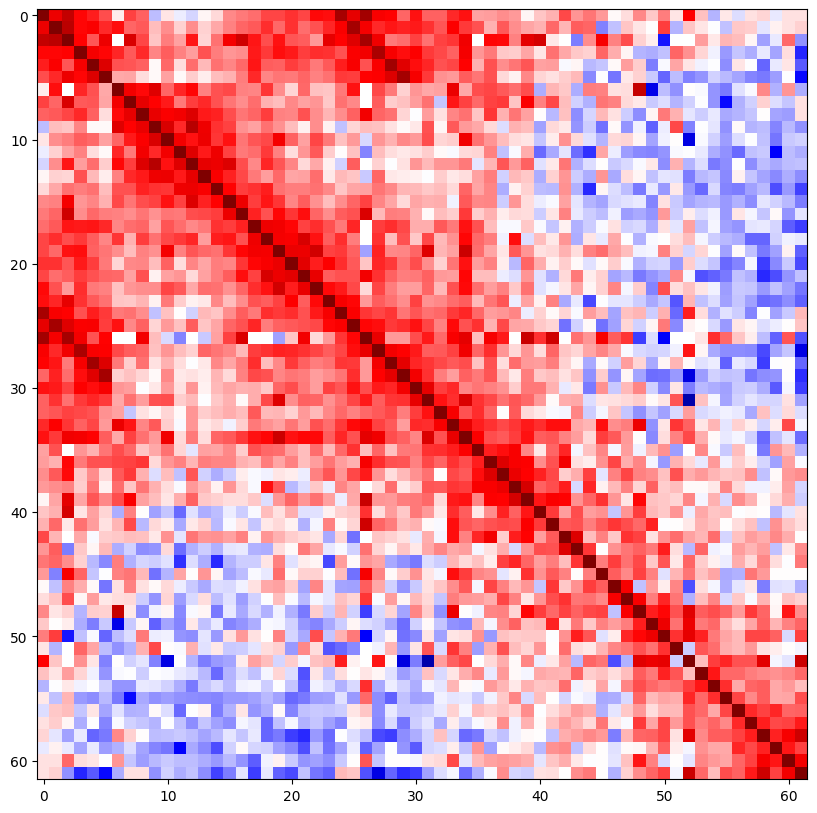

In [21]:
plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1)